# Detail of Direction Conventions

This notebook details all the coordinate systems used throught the camera network and reconstruction pipeline.

In [2]:
%matplotlib inline
from CameraNetwork.image_utils import Normalization
from CameraNetwork.image_utils import FisheyeProxy
import fisheye
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

c:\users\user\documents\code\cameranetwork_git\CameraNetwork\transformation_matrices.py:1934: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## ENU convention

In ENU, the coords are in the following order East, North, Up.

In [3]:
X_, Y_ = np.meshgrid(
    np.linspace(-1, 1, 201),
    np.linspace(-1, 1, 201)
)

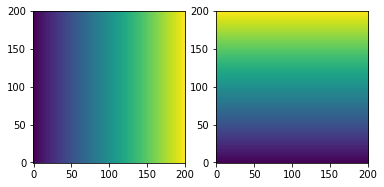

In [4]:
_, ax = plt.subplots(ncols=2)
ax[0].imshow(X_, origin='lower')
ax[1].imshow(Y_, origin='lower')

![title](data\azimuth_zenith.png)

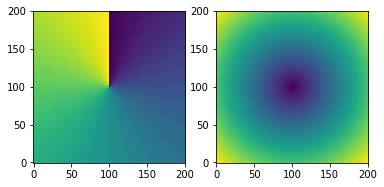

In [5]:
PHI = np.arctan2(-X_, -Y_)
PSI = np.pi/2 * np.sqrt(X_**2 + Y_**2)
_, ax = plt.subplots(ncols=2)
ax[0].imshow(PHI, origin='lower')
ax[1].imshow(PSI, origin='lower')

## Captured Data

### Raw data

In the raw data the coordinates depend on the (random) orientation of the sensor inside the camera.

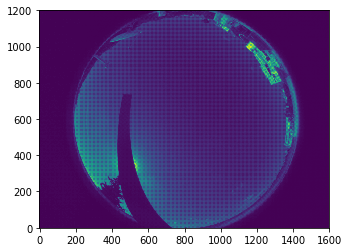

In [6]:
img = sio.loadmat('data/1476876720.0_2016_10_19_11_32_00_2.mat')['img_array']
plt.imshow(img, origin="lower")

### After normalization

After normalization the image horizontal (second, X) axis increases to the east, the vertical axis (first, Y) increases to the north

In [7]:
fe = fisheye.load_model('data/.calibration_data.dat', calib_img_shape=(1200, 1600))
R = np.load('data/.extrinsic_data.npy')
nm = Normalization(resolution=301, fisheye_model=FisheyeProxy(fe), Rot=R)

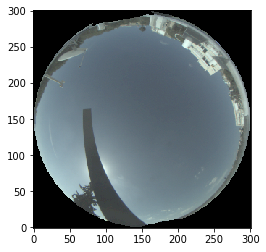

In [8]:
gamma_img = nm.normalize(img)**0.4
plt.imshow(gamma_img/gamma_img.max(), origin="lower")

## PyQtGraph Conventions

From the documentation:

By default, the positive y-axis points upward on the screen. Use invertY(True) to reverse the y-axis (This is the opposite from matplotlib).

Note:
You should run the script below from the command line. It doesn't run from the GUI.

In [16]:
%run ImageView.py

RuntimeError: wrapped C/C++ object of type ViewBox has been deleted

## SHDOM Conventions

From the documentaion:

mu = cosine of the solar zenith angle (this represents the direction of travel of the solar beam, so is forced to be negative although it can be specified positive).

az = solar beam azimuthal angle; specified in degrees but immediately converted to radians for use in code. 0 is beam going in positive X direction, 90 is positive Y.

The axes of the 3D density is arranged as X, Y, Z.

It is important to note that in SHDOM the angles are measured in the directions of the photons.

In the examples below (as used in the reconstruction pipeline). The SDHOM X is going north, the SHDOM Y is going East (and the Z is up). This gives a left hand convention.

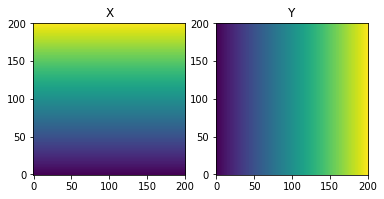

In [13]:
Y_shdom, X_shdom = np.meshgrid(
    np.linspace(-1, 1, 201),
    np.linspace(-1, 1, 201)
)
_, ax = plt.subplots(ncols=2)
ax[0].imshow(X_shdom, origin='lower')
ax[0].set_title("X")
ax[1].imshow(Y_shdom, origin='lower')
ax[1].set_title("Y")

Again, the PHI and PSI are according to the SHDOM convention detailed above. PHI is zero when the photons are going in the X direction (up in the image below, or North in the camera image), PHI is 90 when the photons are going in the Y direction (right in the image below and East in the camera image).
PSI is -PI (downward Zenith angle) in the center of the camera (photons going down into the camera), and increases to -PI/2 at the periphery.

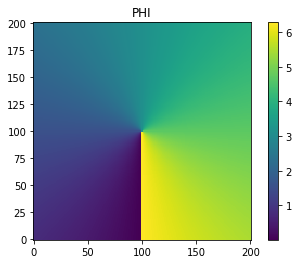

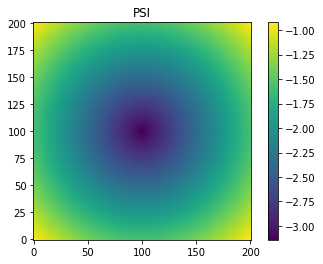

In [12]:
PHI_shdom = np.pi + np.arctan2(Y_shdom, X_shdom)
PSI_shdom = -np.pi + np.pi/2 * np.sqrt(X_shdom**2 + Y_shdom**2)
plt.figure()
plt.imshow(PHI_shdom, origin='lower')
plt.title("PHI")
plt.colorbar()
plt.figure()
plt.imshow(PSI_shdom, origin='lower')
plt.title("PSI")
plt.colorbar()

## MAYAVI Conventions

Mayavi uses the XYZ axes orders. It uses right hand side conventions

## Calculate a mask for the Sun

In [20]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""

    return lambda x, y: height*np.exp(-(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

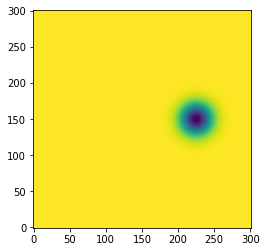

In [40]:
sun_alt, sun_az = np.pi/4, np.pi/2

sun_r = (np.pi/2 - sun_alt) / (np.pi/2)
sun_x = sun_r * np.sin(sun_az)
sun_y = sun_r * np.cos(sun_az)

X, Y = np.meshgrid(np.linspace(-1, 1, 301), np.linspace(-1, 1, 301))
mask = 1- gaussian(1, sun_x, sun_y, 0.1, 0.1)(X, Y)
plt.imshow(mask, origin='bottom')